<a href="https://colab.research.google.com/github/Leorg54/segmenting-and-clustering-paris/blob/main/paris_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmenting and clustering neighborhoods in Paris

## Problem and discussion of the background

Paris is a densely populated city with more than 2 millions of inhabitant for an area of 105 km2 so namely a density of about 20,000 inhabitant per km2. The city is divided into 20 neighborhoods named the arrondissements of Paris, there are numbered from 1 to 20. In broad outline, the more the arrondissement is far away from the center of the city, the higher is the number associated. 


Paris is also one of most touristic places in the world. The city is then combining lots of inhabitants along with many touristic venues like museum, parks, restaurants, and café to satisfy tourists’ desires. We want to classify the arrondissements depending on the venues and the density of inhabitants. We could also determine whether a neighborhood is more likely to attract tourist or inhabitants. This study could thus interest people who wnt to settle in Paris and choose their neighborhood according to the type of arrondissement it is and what venues they can find. 





## Data description

To analyze the problem, we exploited the following data: 
* 	We’ve operated web scrapping on the Wikipedia page giving information about 
the arrondissements of Paris ("Arrondissements of Paris"), such as the arrondissement number, its name, area, population (2017 estimate) and density ("Demographics of Paris"). 
*	We’ve extracted the coordinates of each arrondissement with the geocoder python package.
*	Foursquare API was used to get the most common venues for each given arrondissement of Paris.

Installation of librairies required

In [ ]:
!pip install geocoder
import geocoder

In [ ]:
# import all libraries needed
import requests
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries imported.')

Libraries imported.


## Part 1 - Webscrapping of wikipedia page to extract informations about arrondissements of Paris

In [ ]:
url = "https://en.wikipedia.org/wiki/Arrondissements_of_Paris"
response = requests.get(url)
html = response.content
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
arrondissements_soup =soup.findAll("table")[1] # it's the second table in wikipedia page 

In [ ]:
arrondissements_table = [] # it will contain the information to create the arrondissement dataframe

In [ ]:
# in the page I scrape, 1st to 4th arrondissements are considered to represent only one big arrondissement 
# and the area / population / density are for all 4 arrondissements 
# I thus extracted from another source (demographics of Paris on wikipedia) the exact density of population for each arrondissement 
density_pop_1_4 = [8959, 21254, 29392, 17731]

In [ ]:
# cell contain the information about one arrondissement, it is then appened to the arrondissements_table
cell = {}
first_arr = arrondissements_soup.findAll('tr')[1].findAll('td')
cell['Arrondissement'] = first_arr[0].text.split(' ')[0].replace('(',' (') #we just take the number of the arrondissement
cell['Name'] = first_arr[1].text
cell['Density'] = density_pop_1_4[0]
arrondissements_table.append(cell)

i = 0
for row in arrondissements_soup.findAll('tr')[2:5]:
  i += 1 
  cell = {}
  arrondissement = row.findAll('td')
  cell['Arrondissement'] = arrondissement[0].text.split(' R')[0] #we just take the number of the arrondissement
  cell['Name'] = arrondissement[1].text
  cell['Density'] = density_pop_1_4[i]
  arrondissements_table.append(cell)


for row in arrondissements_soup.findAll('tr')[5:]:
  cell = {}
  arrondissement = row.findAll('td')
  cell['Arrondissement'] = arrondissement[0].text[:-2] #remove the left / right component in the arrondissement number
  cell['Name'] = arrondissement[1].text
  cell['Density'] = arrondissement[4].text.split('³')[0].split('¹')[0].replace(',','')
  # we use split for the exception for arrondissement 12th and 16th where we consider the density without the woods
  arrondissements_table.append(cell)

In [ ]:
arrondissements_df = pd.DataFrame(arrondissements_table)
arrondissements_df

,Arrondissement,Name,Density
0,1st (Ier),Louvre,8959
1,2nd (IIe),Bourse,21254
2,3rd (IIIe),Temple,29392
3,4th (IVe),Hôtel-de-Ville,17731
4,5th (Ve),Panthéon,23477
5,6th (VIe),Luxembourg,19524
6,7th (VIIe),Palais-Bourbon,12761
7,8th (VIIIe),Élysée,9631
8,9th (IXe),Opéra,27556
9,10th (Xe),Entrepôt,31431


In [ ]:
# convert the numerical columns to float type 
arrondissements_df = arrondissements_df.astype({'Density':'int64'}, copy=True)

## Part 2 - extracting geospatial coordinates for every arrondissements 

In [ ]:
#Get geographical coordinates 
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{} Paris'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

lat_Paris, lng_Paris = get_latilong('75000')
print(f'Paris latitude is {lat_Paris} and its longitude is {lng_Paris}')

Paris latitude is 48.878720000000044 and its longitude is 2.345990000000029


In [ ]:
# Each arrondissement is associated to a postal code like 750xx where xx is the arrondissement number. 
postal_code_list = []
for i in range(1,21):
  if i < 10:
    postal_code_list.append(f'7500{i}')
  else:
    postal_code_list.append(f'750{i}')

# update of the dataframe with postal code corresponding to each arrondissement
arrondissements_df['PostalCode'] = postal_code_list
arrondissements_df.head()

,Arrondissement,Name,Density,PostalCode
0,1st (Ier),Louvre,8959,75001
1,2nd (IIe),Bourse,21254,75002
2,3rd (IIIe),Temple,29392,75003
3,4th (IVe),Hôtel-de-Ville,17731,75004
4,5th (Ve),Panthéon,23477,75005


In [ ]:
# extraction of latitude and longitude for each arrondissement
coords = [ get_latilong(postal_code) for postal_code in postal_code_list ]
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
arrondissements_df['Latitude'] = df_coords['Latitude']
arrondissements_df['Longitude'] = df_coords['Longitude']
arrondissements_df

,Arrondissement,Name,Density,PostalCode,Latitude,Longitude
0,1st (Ier),Louvre,8959,75001,48.863415,2.336771
1,2nd (IIe),Bourse,21254,75002,48.867715,2.343093
2,3rd (IIIe),Temple,29392,75003,48.862560,2.359047
3,4th (IVe),Hôtel-de-Ville,17731,75004,48.854275,2.361467
4,5th (Ve),Panthéon,23477,75005,48.845350,2.351892
5,6th (VIe),Luxembourg,19524,75006,48.849265,2.332099
6,7th (VIIe),Palais-Bourbon,12761,75007,48.854620,2.313061
7,8th (VIIIe),Élysée,9631,75008,48.871905,2.311570
8,9th (IXe),Opéra,27556,75009,48.876995,2.337893
9,10th (Xe),Entrepôt,31431,75010,48.876155,2.362330


#### Paris map and its arrondissements

In [ ]:
# create map of Paris 
map_paris = folium.Map(location=[lat_Paris, lng_Paris], zoom_start=12)

# add markers to map
for lat, lng, borough, name in zip(arrondissements_df['Latitude'], arrondissements_df['Longitude'], arrondissements_df['Arrondissement'], arrondissements_df['Name']):
    label = '{}, {} arrondissement'.format(name, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

## Part 3 - Search for venues in each arrondissement

#### Define Foursquare Credentials and Version

In [ ]:
#@title Foursquare Credentials
CLIENT_ID = 'XYIP3Q2ZK2AEBKQIJSPEZ3MIZXBJ5KNBRL1F5NAT2ANZE203' 
CLIENT_SECRET = 'X5OHQ2F1MXPGSFRUCU5OAGPCNOXKY5MQDPIJQEHII2HOGLLX' 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


#### Creation of a function to extract nearby venues in every arrondissement of Paris

In [ ]:
def getNearbyVenues(names, neighborhoods, densities, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, neighborhood, density, lat, lng in zip(names, neighborhoods, densities, latitudes, longitudes):
        print(name, neighborhood)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            neighborhood,
            density,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Arrondissement', 'Neighborhood', 'Density',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
paris_venues = getNearbyVenues(arrondissements_df.loc[:, 'Arrondissement'], arrondissements_df.loc[:, 'Name'], arrondissements_df.loc[:, 'Density'], arrondissements_df.loc[:, 'Latitude'], arrondissements_df.loc[:, 'Longitude'])

1st (Ier) Louvre
2nd (IIe) Bourse
3rd (IIIe) Temple
4th (IVe) Hôtel-de-Ville
5th (Ve) Panthéon
6th (VIe) Luxembourg
7th (VIIe) Palais-Bourbon
8th (VIIIe) Élysée
9th (IXe) Opéra
10th (Xe) Entrepôt
11th (XIe) Popincourt
12th (XIIe) Reuilly
13th (XIIIe) Gobelins
14th (XIVe) Observatoire
15th (XVe) Vaugirard
16th (XVIe) Passy
17th (XVIIe) Batignolles-Monceau
18th (XVIIIe) Butte-Montmartre
19th (XIXe) Buttes-Chaumont
20th (XXe) Ménilmontant


In [ ]:
print(paris_venues.shape)
paris_venues.head()

(1220, 9)


,Arrondissement,Neighborhood,Density,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1st (Ier),Louvre,8959,48.863415,2.336771,Jardin du Palais Royal,48.864941,2.337728,Garden
1,1st (Ier),Louvre,8959,48.863415,2.336771,Palais Royal,48.863236,2.337127,Historic Site
2,1st (Ier),Louvre,8959,48.863415,2.336771,Place du Palais Royal,48.862523,2.336688,Plaza
3,1st (Ier),Louvre,8959,48.863415,2.336771,Comédie-Française,48.863088,2.336612,Theater
4,1st (Ier),Louvre,8959,48.863415,2.336771,La Clef Louvre Paris,48.863977,2.336140,Hotel


#### How many venues have been found for each arrondissement in a radius of 500m ?

In [ ]:
print('There are {} uniques categories.'.format(len(paris_venues['Venue Category'].unique())))

There are 198 uniques categories.


In [ ]:
number_of_venue_by_arr = paris_venues.groupby('Arrondissement')['Venue'].count().sort_values(ascending=True)

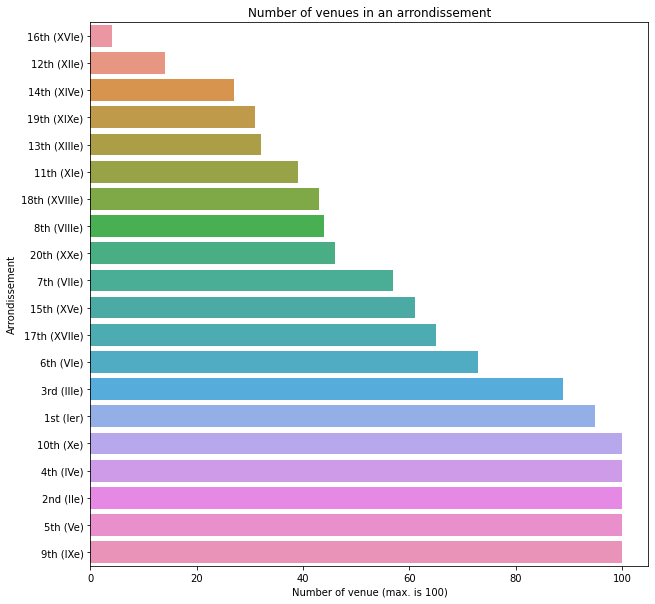

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(y = number_of_venue_by_arr.index, x = number_of_venue_by_arr.values)
plt.xlabel('Number of venue (max. is 100)')
plt.title('Number of venues in an arrondissement')
plt.show()

According to the figure below representing the number of venues in an arrondissement, in this small radius of 500 meters, we can observe that the maximum number of venues found by the API is only achieved for the 9th, 5th, 2nd, 4th and 10th (and almost for the 1st) arrondissements. Here we can note that the more the arrondissement is located in the center of Paris, the more venues there will be in a small radius. 

#### Is the density of venue linked to the density of population ?

We can thus wonder if theses arrondissements also correspond to the most densely populated arrondissements. The figure below do not show a special trend for these neighborhoods with a high density of venue, they can be densely populated (like 9th and 10th arrondissements) or lightly populated (such as the 1st or 2nd arrondissements).

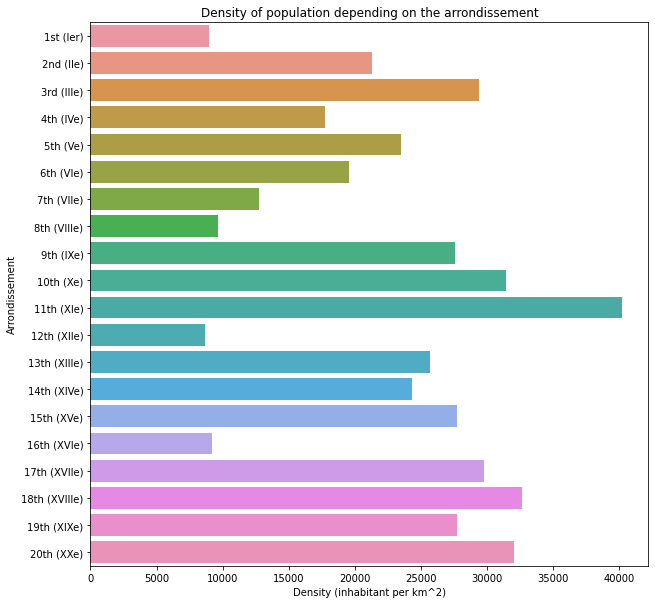

In [ ]:
plt.figure(figsize=(10,10))
barplot = sns.barplot(x = "Density", y = "Arrondissement", data = arrondissements_df)
plt.xlabel('Density (inhabitant per km^2)')
plt.title("Density of population depending on the arrondissement")
plt.show()

## Part 4 - Data preparation for k-means clustering

#### Analyse each neighborhood

In [ ]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Density'] = paris_venues['Density']
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 
paris_onehot['Arrondissement'] = paris_venues['Arrondissement'] 


# move neighborhood, arrondissement and density columns to the firsts columns
fixed_columns = [paris_onehot.columns[-1]] + [paris_onehot.columns[-2]] + [paris_onehot.columns[-3]] + list(paris_onehot.columns[:-3])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Arrondissement,Neighborhood,Density,Afghan Restaurant,African Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,Bagel Shop,Bakery,Bank,Bar,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Trail,Bistro,Bookstore,Botanical Garden,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Cambodian Restaurant,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Donut Shop,Electronics Store,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General College & University,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lebanese Restaurant,Library,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,New American Restaurant,Noodle House,Okonomiyaki Restaurant,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Ramen Restaurant,Recreation Center,Resort,Restaurant,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,1st (Ier),Louvre,8959,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1st (Ier),Louvre,8959,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1st (Ier),Louvre,8959,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category. We also need to normalize the density column to take it into account for the k-means algorithm


In [ ]:
paris_grouped = paris_onehot.groupby(['Arrondissement','Neighborhood']).mean().reset_index()
# normalization for k means
paris_grouped.Density = paris_grouped.Density / (paris_grouped.Density.max())
paris_grouped.head()

,Arrondissement,Neighborhood,Density,Afghan Restaurant,African Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,Bagel Shop,Bakery,Bank,Bar,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Rental / Bike Share,Bike Trail,Bistro,Bookstore,Botanical Garden,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Line,Bus Station,Bus Stop,Café,Cambodian Restaurant,Candy Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Doner Restaurant,Donut Shop,Electronics Store,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Fountain,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,General College & University,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Lebanese Restaurant,Library,Liquor Store,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,New American Restaurant,Noodle House,Okonomiyaki Restaurant,Outdoor Sculpture,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pharmacy,Pizza Place,Playground,Plaza,Pool,Portuguese Restaurant,Provençal Restaurant,Pub,Ramen Restaurant,Recreation Center,Resort,Restaurant,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Snack Place,Soba Restaurant,South American Restaurant,Southwestern French Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Stadium,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Trail,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,10th (Xe),Entrepôt,0.782196,0.000000,0.02,0.0,0.0,0.0,0.000000,0.0,0.030000,0.0,0.0,0.0,0.030000,0.000000,0.040000,0.0,0.0,0.0,0.01,0.0,0.000000,0.000000,0.050000,0.01,0.000000,0.01,0.000000,0.0,0.02,0.000000,0.0,0.02,0.0,0.0,0.0000,0.050000,0.00000,0.0,0.0,0.01000,0.0,0.0,0.0,0.010000,0.050000,0.000000,0.000000,0.0,0.00000,0.0,0.01,0.01000,0.0,0.0,0.0,0.0,0.01000,0.01,0.01,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.010000,0.0,0.000000,0.01,0.010000,0.0,0.110000,0.0,0.01,0.01,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.01,0.040000,0.0,0.01,0.01,0.0,0.0,0.0,0.01,0.030000,0.01,0.0,0.0,0.01000,0.0,0.020000,0.0,0.000000,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.02,0.0,0.0,0.0,0.000000,0.01,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.000000,0.010000,0.0,0.000000,0.0,0.0,0.0,0.0,0.030000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.020000,0.0,0.0,0.0,0.01,0.010000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.01,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.0,0.000000,0.0,0.000000,0.020000,

Function to sort the values

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Arrondissement','Neighborhood','Density']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted[['Arrondissement', 'Neighborhood', 'Density']] = paris_grouped[['Arrondissement', 'Neighborhood', 'Density']]


for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 3:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Arrondissement,Neighborhood,Density,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10th (Xe),Entrepôt,0.782196,French Restaurant,Coffee Shop,Bistro,Café,Hotel,Bar,Bakery,Wine Bar,Italian Restaurant,Asian Restaurant
1,11th (XIe),Popincourt,1.000000,Café,Restaurant,Pastry Shop,Italian Restaurant,French Restaurant,Bar,Coffee Shop,Pizza Place,Brewery,Sandwich Place
2,12th (XIIe),Reuilly,0.215439,Theater,Recreation Center,Restaurant,Playground,Fast Food Restaurant,Performing Arts Venue,Comedy Club,Botanical Garden,Bike Rental / Bike Share,Bike Trail
3,13th (XIIIe),Gobelins,0.638330,Vietnamese Restaurant,French Restaurant,Hotel,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Bus Stop,Creperie,Juice Bar,Cambodian Restaurant
4,14th (XIVe),Observatoire,0.604236,French Restaurant,Hotel,Thai Restaurant,Food & Drink Shop,Brasserie,Fast Food Restaurant,Sushi Restaurant,Bank,Tea Room,Bakery
5,15th (XVe),Vaugirard,0.690167,French Restaurant,Hotel,Italian Restaurant,Bakery,Coffee Shop,Bistro,Indian Restaurant,Lebanese Restaurant,Japanese Restaurant,Park
6,16th (XVIe),Passy,0.228181,Pool,Park,Lake,Circus,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
7,17th (XVIIe),Batignolles-Monceau,0.740612,French Restaurant,Hotel,Italian Restaurant,Japanese Restaurant,Bakery,Plaza,Café,Restaurant,Bistro,Bar
8,18th (XVIIIe),Butte-Montmartre,0.812134,French Restaurant,Bar,Italian Restaurant,Convenience Store,Restaurant,Café,Fast Food Restaurant,Gastropub,Bistro,Mediterranean Restaurant
9,19th (XIXe),Buttes-Chaumont,0.689272,French Restaurant,Supermarket,Doner Restaurant,Bike Rental / Bike Share,Spa,Burger Joint,Seafood Restaurant,Scenic Lookout,Café,Concert Hall


## Part 5 - Clustering of neighborhoods with k-means clustering

In [ ]:
# set number of clusters
kclusters = 3

paris_grouped_clustering = paris_grouped.drop(['Neighborhood', 'Arrondissement'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# drop density column
neighborhoods_venues_sorted.drop(['Density'], axis=1, inplace=True)
paris_grouped_clustering.drop(['Density'], axis=1, inplace= True)

paris_merged = arrondissements_df


In [ ]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Arrondissement,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,10th (Xe),Entrepôt,French Restaurant,Coffee Shop,Bistro,Café,Hotel,Bar,Bakery,Wine Bar,Italian Restaurant,Asian Restaurant
1,1,11th (XIe),Popincourt,Café,Restaurant,Pastry Shop,Italian Restaurant,French Restaurant,Bar,Coffee Shop,Pizza Place,Brewery,Sandwich Place
2,2,12th (XIIe),Reuilly,Theater,Recreation Center,Restaurant,Playground,Fast Food Restaurant,Performing Arts Venue,Comedy Club,Botanical Garden,Bike Rental / Bike Share,Bike Trail
3,1,13th (XIIIe),Gobelins,Vietnamese Restaurant,French Restaurant,Hotel,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Bus Stop,Creperie,Juice Bar,Cambodian Restaurant
4,1,14th (XIVe),Observatoire,French Restaurant,Hotel,Thai Restaurant,Food & Drink Shop,Brasserie,Fast Food Restaurant,Sushi Restaurant,Bank,Tea Room,Bakery


In [ ]:
# merge paris_grouped with arrondissements_df to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Arrondissement'), on='Arrondissement')
paris_merged.drop('Neighborhood', inplace=True, axis=1)
paris_merged.head() 

,Arrondissement,Name,Density,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1st (Ier),Louvre,8959,75001,48.863415,2.336771,0,French Restaurant,Japanese Restaurant,Plaza,Italian Restaurant,Hotel,Wine Bar,Historic Site,Coffee Shop,Art Museum,Brasserie
1,2nd (IIe),Bourse,21254,75002,48.867715,2.343093,1,French Restaurant,Wine Bar,Hotel,Cocktail Bar,Italian Restaurant,Coffee Shop,Salad Place,Bistro,Bakery,Creperie
2,3rd (IIIe),Temple,29392,75003,48.862560,2.359047,1,French Restaurant,Japanese Restaurant,Gourmet Shop,Bakery,Burger Joint,Italian Restaurant,Sandwich Place,Cocktail Bar,Coffee Shop,Wine Bar
3,4th (IVe),Hôtel-de-Ville,17731,75004,48.854275,2.361467,0,French Restaurant,Ice Cream Shop,Clothing Store,Hotel,Italian Restaurant,Wine Bar,Bakery,Plaza,Tea Room,Park
4,5th (Ve),Panthéon,23477,75005,48.845350,2.351892,1,French Restaurant,Bar,Pub,Hotel,Bakery,Coffee Shop,Italian Restaurant,Café,Creperie,Wine Bar


#### Visualisation of the resulting clusters

In [ ]:
# create map
map_clusters = folium.Map(location=[lat_Paris, lng_Paris], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, name, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Arrondissement'], paris_merged['Name'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' arrondissement,' + str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can notice that neighborhoods in cluster 0 (in red) seem to be located in the heart of Paris whereas neighborhoods of cluster 2 (in green) are located in the outskirt of Paris and they are characterized by their location near woods (the Bois de Vincennes and Bois de Boulogne). That is an interesting behavior given that the location of neighborhoods where not considered when modeling with k-means algorithm. 

## Part 6 - Cluster analysis

### Details about clusters

#### Cluster 0

In [ ]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0]

,Arrondissement,Name,Density,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1st (Ier),Louvre,8959,75001,48.863415,2.336771,0,French Restaurant,Japanese Restaurant,Plaza,Italian Restaurant,Hotel,Wine Bar,Historic Site,Coffee Shop,Art Museum,Brasserie
3,4th (IVe),Hôtel-de-Ville,17731,75004,48.854275,2.361467,0,French Restaurant,Ice Cream Shop,Clothing Store,Hotel,Italian Restaurant,Wine Bar,Bakery,Plaza,Tea Room,Park
5,6th (VIe),Luxembourg,19524,75006,48.849265,2.332099,0,French Restaurant,Fountain,Restaurant,Plaza,Chocolate Shop,Hotel,Seafood Restaurant,Tea Room,Italian Restaurant,Bakery
6,7th (VIIe),Palais-Bourbon,12761,75007,48.854620,2.313061,0,Hotel,French Restaurant,Café,Plaza,Italian Restaurant,History Museum,Garden,Bistro,Historic Site,Coffee Shop
7,8th (VIIIe),Élysée,9631,75008,48.871905,2.311570,0,French Restaurant,Hotel,Cosmetics Shop,Art Gallery,Italian Restaurant,Spa,Corsican Restaurant,Plaza,Hotel Bar,Grocery Store


#### Cluster 1

In [ ]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1]

,Arrondissement,Name,Density,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,2nd (IIe),Bourse,21254,75002,48.867715,2.343093,1,French Restaurant,Wine Bar,Hotel,Cocktail Bar,Italian Restaurant,Coffee Shop,Salad Place,Bistro,Bakery,Creperie
2,3rd (IIIe),Temple,29392,75003,48.862560,2.359047,1,French Restaurant,Japanese Restaurant,Gourmet Shop,Bakery,Burger Joint,Italian Restaurant,Sandwich Place,Cocktail Bar,Coffee Shop,Wine Bar
4,5th (Ve),Panthéon,23477,75005,48.845350,2.351892,1,French Restaurant,Bar,Pub,Hotel,Bakery,Coffee Shop,Italian Restaurant,Café,Creperie,Wine Bar
8,9th (IXe),Opéra,27556,75009,48.876995,2.337893,1,French Restaurant,Hotel,Bistro,Japanese Restaurant,Bakery,Wine Bar,Lounge,Bar,Cocktail Bar,Tea Room
9,10th (Xe),Entrepôt,31431,75010,48.876155,2.362330,1,French Restaurant,Coffee Shop,Bistro,Café,Hotel,Bar,Bakery,Wine Bar,Italian Restaurant,Asian Restaurant
10,11th (XIe),Popincourt,40183,75011,48.859775,2.378126,1,Café,Restaurant,Pastry Shop,Italian Restaurant,French Restaurant,Bar,Coffee Shop,Pizza Place,Brewery,Sandwich Place
12,13th (XIIIe),Gobelins,25650,75013,48.830090,2.362283,1,Vietnamese Restaurant,French Restaurant,Hotel,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Bus Stop,Creperie,Juice Bar,Cambodian Restaurant
13,14th (XIVe),Observatoire,24280,75014,48.829795,2.323828,1,French Restaurant,Hotel,Thai Restaurant,Food & Drink Shop,Brasserie,Fast Food Restaurant,Sushi Restaurant,Bank,Tea Room,Bakery
14,15th (XVe),Vaugirard,27733,75015,48.841734,2.296975,1,French Restaurant,Hotel,Italian Restaurant,Bakery,Coffee Shop,Bistro,Indian Restaurant,Lebanese Restaurant,Japanese Restaurant,Park
16,17th (XVIIe),Batignolles-Monceau,29760,75017,48.887070,2.306293,1,French Restaurant,Hotel,Italian Restaurant,Japanese Restaurant,Bakery,Plaza,Café,Restaurant,Bistro,Bar


#### Cluster 2

In [ ]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2]

,Arrondissement,Name,Density,PostalCode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,12th (XIIe),Reuilly,8657,75012,48.83512,2.444957,2,Theater,Recreation Center,Restaurant,Playground,Fast Food Restaurant,Performing Arts Venue,Comedy Club,Botanical Garden,Bike Rental / Bike Share,Bike Trail
15,16th (XVIe),Passy,9169,75016,48.85712,2.255971,2,Pool,Park,Lake,Circus,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant


#### 1st most common venue depending of the cluster?

In [ ]:
cluster1 = paris_merged.loc[paris_merged['Cluster Labels'] == 0]["1st Most Common Venue"].value_counts()/paris_merged.loc[paris_merged['Cluster Labels'] == 0].shape[0]
cluster2 = paris_merged.loc[paris_merged['Cluster Labels'] == 1]["1st Most Common Venue"].value_counts()/paris_merged.loc[paris_merged['Cluster Labels'] == 1].shape[0]
cluster3 = paris_merged.loc[paris_merged['Cluster Labels'] == 2]["1st Most Common Venue"].value_counts()/paris_merged.loc[paris_merged['Cluster Labels'] == 2].shape[0]

most_common = pd.concat([cluster1, cluster2, cluster3], keys = ['cluster 0', 'cluster 1', 'cluster 2'], names = ['cluster', '1st most common venue']).unstack()

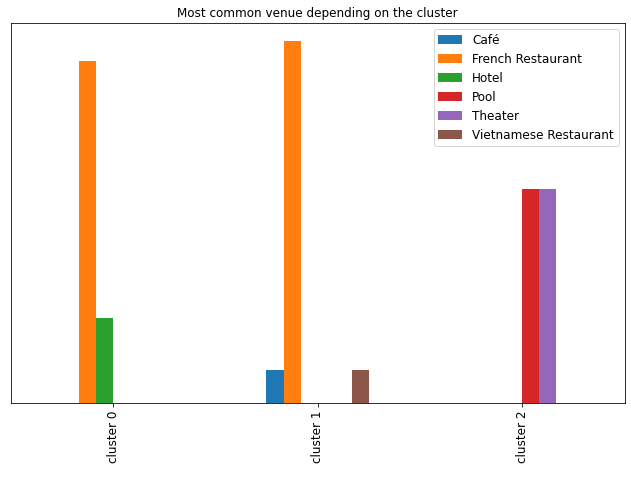

In [ ]:
most_common.plot(kind = 'bar', figsize=(11,7), fontsize=12, yticks=[])
plt.xlabel(' ')
plt.legend(loc='upper right', ncol=1, fontsize=12)
plt.title('Most common venue depending on the cluster')
plt.show()

#### 2nd most common venue depending of the cluster?

In [ ]:
cluster1 = paris_merged.loc[paris_merged['Cluster Labels'] == 0]["2nd Most Common Venue"].value_counts()/paris_merged.loc[paris_merged['Cluster Labels'] == 0].shape[0]
cluster2 = paris_merged.loc[paris_merged['Cluster Labels'] == 1]["2nd Most Common Venue"].value_counts()/paris_merged.loc[paris_merged['Cluster Labels'] == 1].shape[0]
cluster3 = paris_merged.loc[paris_merged['Cluster Labels'] == 2]["2nd Most Common Venue"].value_counts()/paris_merged.loc[paris_merged['Cluster Labels'] == 2].shape[0]

second_most_common = pd.concat([cluster1, cluster2, cluster3], keys = ['cluster 0', 'cluster 1', 'cluster 2'], names = ['cluster', '2nd most common venue']).unstack()

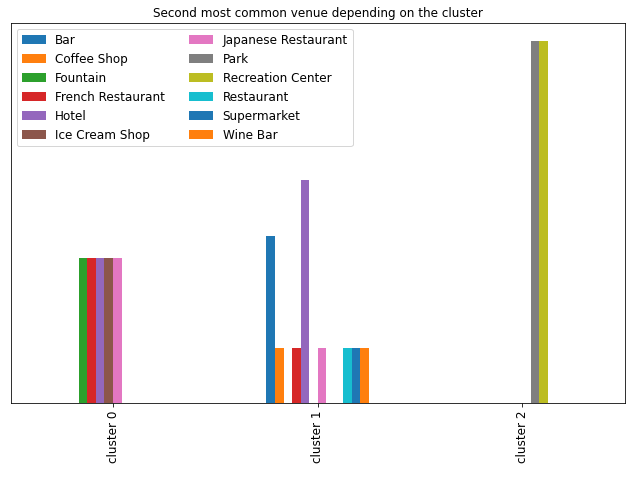

In [ ]:
second_most_common.plot(kind = 'bar', figsize=(11,7), fontsize=12, yticks=[])
plt.xlabel(' ')
plt.legend(loc='upper left', ncol=2, fontsize=12)
plt.title('Second most common venue depending on the cluster')
plt.show()

#### 3rd most common venue depending of the cluster?

In [ ]:
cluster1 = paris_merged.loc[paris_merged['Cluster Labels'] == 0]["3rd Most Common Venue"].value_counts()/paris_merged.loc[paris_merged['Cluster Labels'] == 0].shape[0]
cluster2 = paris_merged.loc[paris_merged['Cluster Labels'] == 1]["3rd Most Common Venue"].value_counts()/paris_merged.loc[paris_merged['Cluster Labels'] == 1].shape[0]
cluster3 = paris_merged.loc[paris_merged['Cluster Labels'] == 2]["3rd Most Common Venue"].value_counts()/paris_merged.loc[paris_merged['Cluster Labels'] == 2].shape[0]

third_most_common = pd.concat([cluster1, cluster2, cluster3], keys = ['cluster 0', 'cluster 1', 'cluster 2'], names = ['cluster', '3rd most common venue']).unstack()

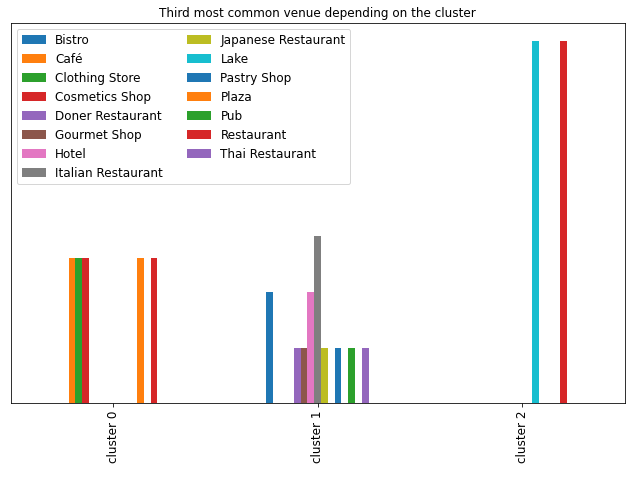

In [ ]:
third_most_common.plot(kind = 'bar', figsize=(11,7), fontsize=12, yticks=[])
plt.title('Third most common venue depending on the cluster')
plt.xlabel(' ')
plt.legend(loc='upper left', ncol=2, fontsize=12)
plt.show()

#### Average density of inhabitants per cluster

In [ ]:
cluster1 = paris_merged.loc[paris_merged['Cluster Labels'] == 0]["Density"].mean()
cluster2 = paris_merged.loc[paris_merged['Cluster Labels'] == 1]["Density"].mean()
cluster3 = paris_merged.loc[paris_merged['Cluster Labels'] == 2]["Density"].mean()

avg_dens_per_cluster = pd.DataFrame({'Cluster': [0,1,2], 'Average_density': [cluster1, cluster2, cluster3]})

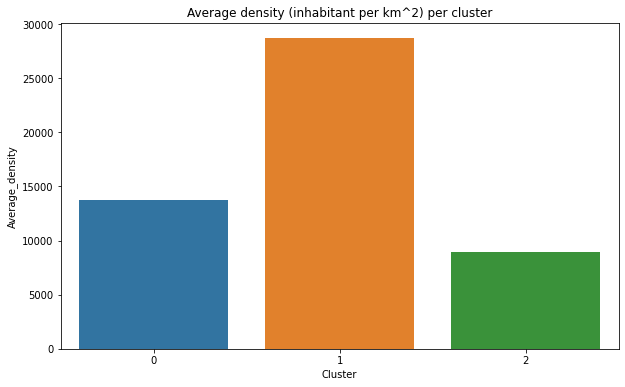

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x = 'Cluster', y = 'Average_density', data = avg_dens_per_cluster)
plt.title('Average density (inhabitant per km^2) per cluster')
plt.show()

### Analysis

The bar plots exposed show the characteristics of the 3 clusters. One major difference between clusters is the density of population. The density of cluster 0, in the heart of Paris, is moderate, the density of cluster 1 is high and the density of cluster 2, in the outskirt of Paris, is quite low. To better understand the way k-means algorithm had clustered the neighborhoods, a bar plot of the 1st most common venue in the different cluster is plotted. The major difference between cluster 0 / 1 and 2 appears to be the presence of French restaurants. Both cluster 0 and 1 have French restaurants as the most common venue whereas for cluster 2 it is pool or theater. When it comes to the second most common venue depending on the cluster, we note that cluster 0 and 1 have many different venues but they still are some places to get together for a drink or a meal: bar, coffee shop, restaurants… We also see that there are some hotels in these neighborhoods. On the other hand, cluster 2 second most common venues are park and recreation centers, so venues to do some activities less focus on sharing drink or food and more into sports or nature. In summary, cluster 0 and 1 have similar venues in their surroundings and their major difference lies in the difference in their density of population. Cluster 2 gathers neighborhoods closer to the nature and of activities focused on sports and nature.

What is very interesting is that when we dig a bit more on the internet to understand the space of touristic places in the different arrondissements, we realize that cluster 0 gather all the arrondissements (1st, 4th, 6th, 7th, 8th) that have the most famous places of Paris. In the 1st arrondissement there are the Jardin des Tuileries along with the Louvre, in the 4th, Notre-Dame de Paris, Pompidou museum, in the 6th, the Palais du Luxembourg along with its Jardins, the Pont des Arts (bridge with love locks), in the 7th, there are the Eiffel Tower and Orsay museum, finally in the 8th, there are the Arc-de-Triomphe, the Grand Palais and the Champs-Elysées…  The presence of all these touristic places makes these arrondissements less welcoming to the Parisians and are more focused on tourists, that is why we’ve observed that these neighborhoods have mid/low density of population whereas it has many similar venues as cluster 1. 

## Conclusion

To conclude, cluster 1 represents the arrondissements that people choose if they prefer being away from tourism and benefit from a real neighborhood life along with some nice place to have a drink or meal with friends. Cluster 0 is made for people who are not bothered to meet too many tourists and like the same king of places than in cluster 0. Finally, cluster 2 is the arrondissements for people who prefer to be in the outskirts of town and access more easily to nature and sport facilities. 